# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import time
import tarfile
import tensorflow as tf
print tf.__file__ ###
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

/home/censhusheng/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

## Load a (frozen) Tensorflow model into memory.

In [12]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/world/data-c9/censhusheng/train_tf_text_loc/inference_graph-2.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'data/text_label_map.pbtxt'
NUM_CLASSES = 1

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_indexs = label_map_util.create_category_index(categories)

## Helper code

In [6]:
def resize(image, min_size):
    width, height = image.size
    if height < width:
        new_height = int(min_size)
        new_width = int(width * min_size / height)
        if new_width % 32 != 0:
            new_width -= new_width%32
    else:
        new_width = int(min_size)
        new_height = int(height * min_size / width)
        if new_height % 32 != 0:
            new_height -= new_height%32
    print 'resize:', (width, height), '->', (new_width, new_height) ###
    return image.resize((new_width, new_height), Image.BILINEAR)


MIN_SIZE = 640

def load_image_into_numpy_array(input_image):
    image = resize(input_image, MIN_SIZE)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


import math
def rbox_2_polygon(xc, yc, w, h, rad):
    w2 = w/2
    h2 = h/2
    m_rot = np.array([[np.cos(rad), -np.sin(rad)], 
                      [np.sin(rad), np.cos(rad)]], dtype=np.float32)
    pts_ = np.array([[-w2,-h2],
                     [w2,-h2],
                     [w2,h2],
                     [-w2,h2]], dtype=np.float32)
    pts = np.dot(m_rot, pts_.T).T
    pts[:,0] = pts[:,0] + xc
    pts[:,1] = pts[:,1] + yc
    return pts.flatten().tolist()



from skimage.draw import polygon
def show_polygons(im, polygons):
    assert polygons.shape[1] == 8
    for p in polygons:
        rr, cc = polygon(p[1::2], p[0::2])
        rr = np.clip(rr, 0, im.shape[0]-1)
        cc = np.clip(cc, 0, im.shape[1]-1)
        alpha = 0.5 # set alpha of marker
        im[rr, cc, 0] = alpha * 255 + im[rr, cc, 0] * (1 - alpha)
        im[rr, cc, 1] = im[rr, cc, 1] * (1 - alpha)
        im[rr, cc, 2] = im[rr, cc, 2] * (1 - alpha)
        im[p[1]-1:p[1]+2, p[0]-1:p[0]+2] = np.array([0,255,0], dtype=np.uint8) # green for start point
        im[p[3]-1:p[3]+2, p[2]-1:p[2]+2] = np.array([0,0,255], dtype=np.uint8) # blue for end point
    plt.imshow(im);plt.show()
    
plt.rcParams['figure.figsize'] = (20.0, 12.0)

# LA-NMS

In [7]:
sys.path.append(os.path.expanduser('~/github/EAST/'))
import lanms
print lanms

<module 'lanms' from '/home/censhusheng/github/EAST/lanms/__init__.pyc'>


# Detection

In [8]:
TEST_IMAGE_PATHS = [
    '/world/data-c7/censhusheng/data/MSRA-TD500/test/IMG_0059.JPG',
    '/world/data-c7/censhusheng/data/MSRA-TD500/test/IMG_0080.JPG',
    '/world/data-c7/censhusheng/data/MSRA-TD500/train/IMG_0030.JPG',
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/test_images/img_1.jpg',
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/test_images/img_2.jpg',
]


resize: (1920, 1280) -> (960, 640)
time: 9.32058811188 num_detections: [ 2239.]
convert time: 0.0843200683594
nms_time: 0.014386177063 boxes: 5


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


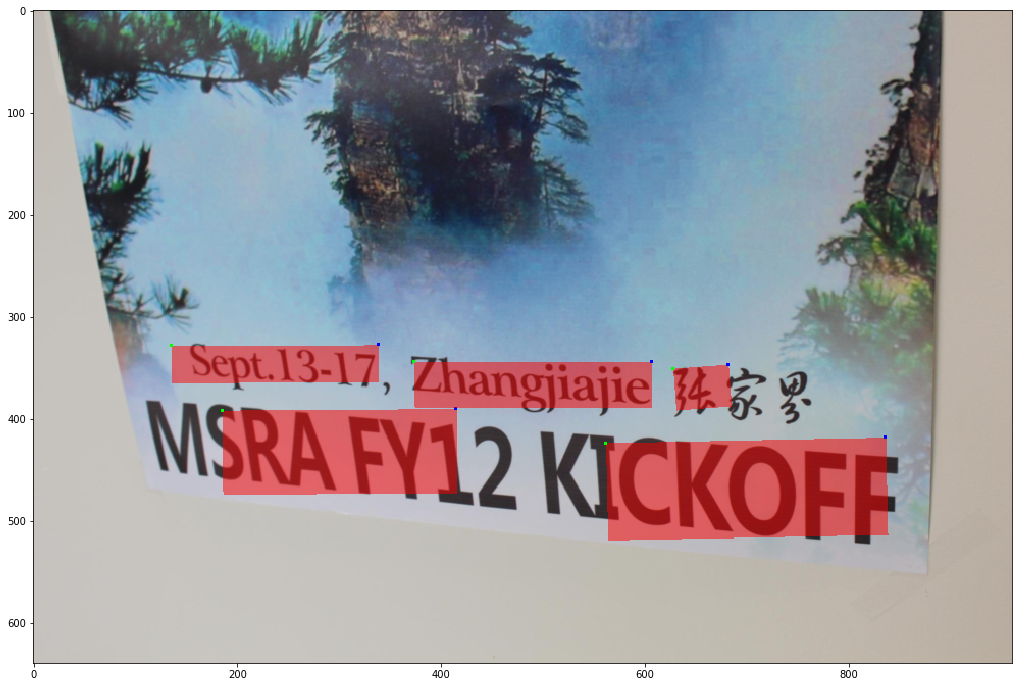

resize: (1920, 1280) -> (960, 640)
time: 0.0502490997314 num_detections: [ 664.]
convert time: 0.0298101902008
nms_time: 0.00752997398376 boxes: 7


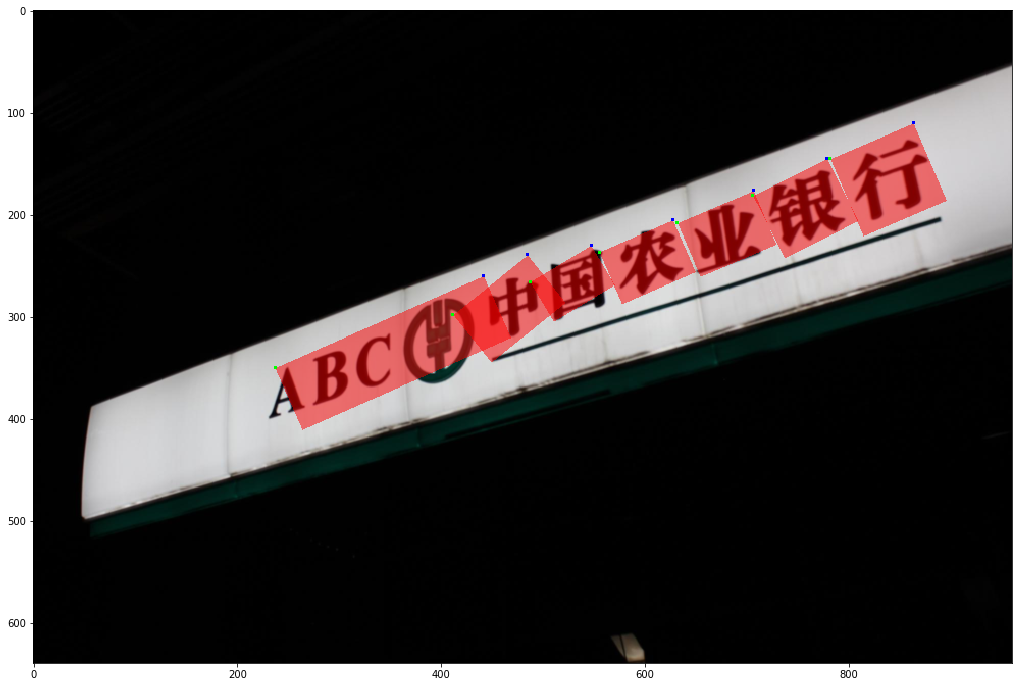

resize: (1728, 1152) -> (960, 640)
time: 1.32801604271 num_detections: [ 15.]
convert time: 0.00202918052673
nms_time: 0.000344038009644 boxes: 2


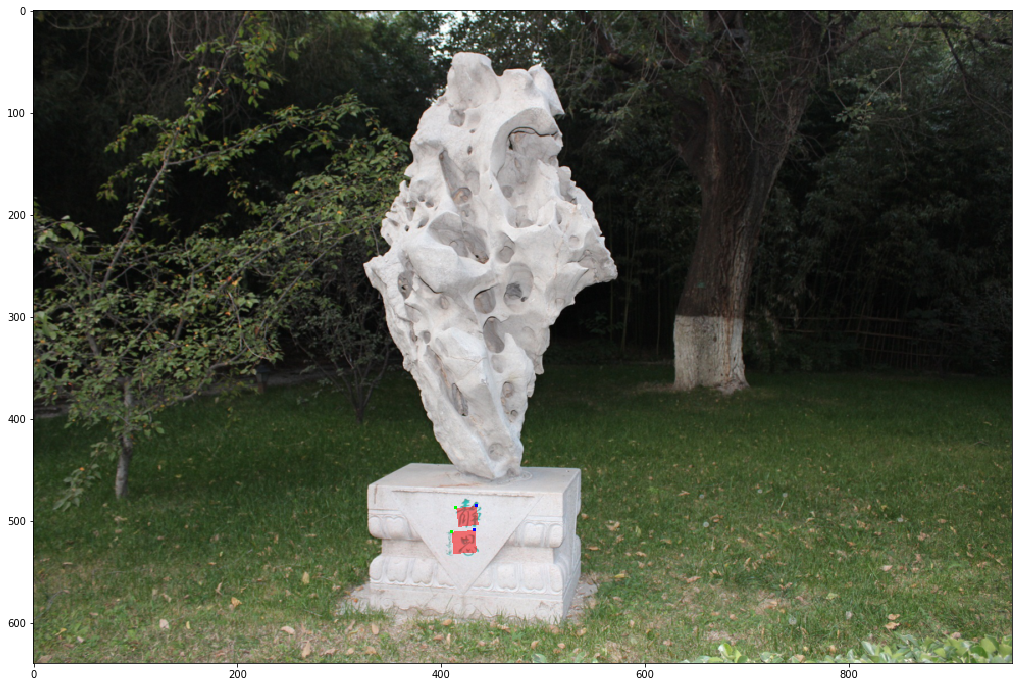

resize: (1280, 720) -> (1120, 640)
time: 0.0401918888092 num_detections: [ 41.]
convert time: 0.00178694725037
nms_time: 0.000479936599731 boxes: 4


resize: (1280, 720) -> (1120, 640)
time: 0.0398790836334 num_detections: [ 353.]
convert time: 0.0131540298462
nms_time: 0.00453591346741 boxes: 28


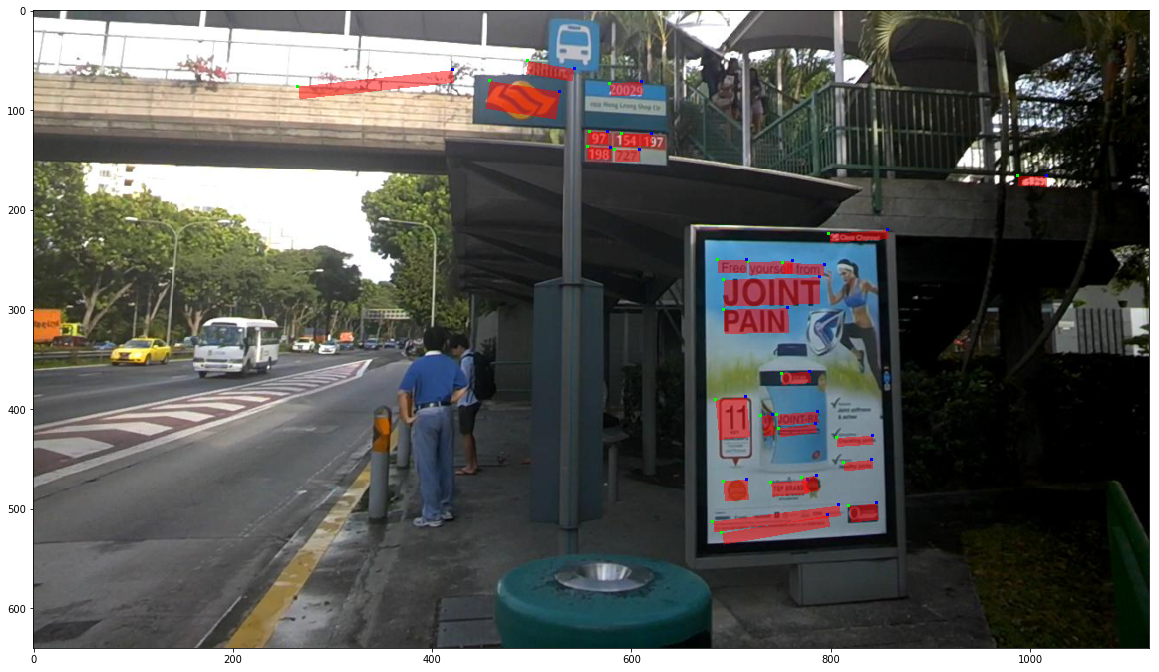

In [13]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
            # Actual detection.
            t0 = time.time()
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            print 'time:', time.time() - t0, 'num_detections:', num_detections ###

            # convert rbox to polygon
            t0 = time.time()
            boxes = np.squeeze(boxes)
            yc = (boxes[:,0] + boxes[:,2]) / 2
            xc = (boxes[:,1] + boxes[:,3]) / 2
            h = boxes[:,2] - boxes[:,0]
            w = boxes[:,3] - boxes[:,1]
            scores = np.squeeze(scores)
            polys = []
            for i in range(num_detections[0]):
                polys.append(rbox_2_polygon(xc[i], yc[i], w[i], h[i], boxes[i,4]) + [scores[i]])
            polys = np.array(polys, dtype=np.float32)
            print 'convert time:', time.time() - t0
            
            # lanms            
            nms_thres = 0.2
            t0 = time.time()
            polys = lanms.merge_quadrangle_n9(polys, nms_thres)
            print 'nms_time:', time.time() - t0, 'boxes:', polys.shape[0] 
            
            # Visualization of the results of a detection.
            show_polygons(image_np, polys[:,:8])

# predict on ICDAR2015 test set

In [14]:
data_dir = '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/test_images/'

output_dir = '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/script_test/test/'

In [34]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for fn in os.listdir(data_dir):
            print fn ###
            t_ = time.time()
            image = Image.open(os.path.join(data_dir, fn))
            width, height = image.size
            image_np = load_image_into_numpy_array(image)
            new_width, new_height = image.size
            ratio_x = float(width)/image_np.shape[1]
            ratio_y = float(height)/image_np.shape[0]
            print image_np.shape, ratio_x, ratio_y ###
            print 'resize time:', time.time() - t_ ###
            
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')


            # Actual detection.
            t0 = time.time()
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            print 'net time:', time.time() - t0, 'num_detections:', num_detections ###

            # convert rbox to polygon
            t0 = time.time()
            boxes = np.squeeze(boxes)
            yc = (boxes[:,0] + boxes[:,2]) / 2
            xc = (boxes[:,1] + boxes[:,3]) / 2
            h = boxes[:,2] - boxes[:,0]
            w = boxes[:,3] - boxes[:,1]
            scores = np.squeeze(scores)
            polys = []
            for i in range(num_detections[0]):
                polys.append(rbox_2_polygon(xc[i], yc[i], w[i], h[i], boxes[i,4]) + [scores[i]])
            polys = np.array(polys, dtype=np.float32)
            print 'convert time:', time.time() - t0 ###
            
            # lanms            
            nms_thres = 0.2
            t0 = time.time()
            polys = lanms.merge_quadrangle_n9(polys, nms_thres)
            print 'nms_time:', time.time() - t0, 'boxes:', polys.shape[0]  ###
            
            # save results
            res_fn = 'res_' + os.path.splitext(fn)[0] + '.txt'
            with open(os.path.join(output_dir, res_fn), 'w') as f_res:
                for p in polys:
                    f_res.write("{:d},{:d},{:d},{:d},{:d},{:d},{:d},{:d}\r\n".format(
                        int(p[0] * ratio_x),
                        int(p[1] * ratio_y),
                        int(p[2] * ratio_x),
                        int(p[3] * ratio_y),
                        int(p[4] * ratio_x),
                        int(p[5] * ratio_y),
                        int(p[6] * ratio_x),
                        int(p[7] * ratio_y),
                    ))
            print 'total time:', time.time() - t_

img_53.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.673863887787
net time: 2.70133209229 num_detections: [ 114.]
convert time: 0.00795102119446
nms_time: 0.00250506401062 boxes: 3
total time: 3.39192390442
img_158.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.830001831055
net time: 0.0411989688873 num_detections: [ 137.]
convert time: 0.00562596321106
nms_time: 0.00123906135559 boxes: 6
total time: 0.884827852249
img_228.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.862149953842
net time: 0.041631937027 num_detections: [ 469.]
convert time: 0.0280039310455
nms_time: 0.00530695915222 boxes: 4
total time: 0.947410106659
img_74.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.761878013611
net time: 0.0424242019653 num_detections: [ 504.]
convert time: 0.030366897583
nms_time: 0.0061240196228 boxes: 11
total time: 0.850639

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.729516983032
net time: 0.0402019023895 num_detections: [ 81.]
convert time: 0.00343298912048
nms_time: 0.0013370513916 boxes: 5
total time: 0.779983043671
img_311.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.664916992188
net time: 0.0390629768372 num_detections: [ 165.]
convert time: 0.00637483596802
nms_time: 0.00127005577087 boxes: 2
total time: 0.716671943665
img_426.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.666877031326
net time: 0.0401039123535 num_detections: [ 340.]
convert time: 0.0129859447479
nms_time: 0.00232911109924 boxes: 4
total time: 0.729943037033
img_261.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.69981098175
net time: 0.0414378643036 num_detections: [ 184.]
convert time: 0.00719213485718
nms_time: 0.00188302993774 boxes: 9
total time: 0.757035017014
img_422.jpg
resize: (1280, 720) -> 

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.785328865051
net time: 0.0393390655518 num_detections: [ 195.]
convert time: 0.00739693641663
nms_time: 0.00173115730286 boxes: 10
total time: 0.83922290802
img_269.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.740625858307
net time: 0.0395181179047 num_detections: [ 336.]
convert time: 0.0125050544739
nms_time: 0.00264000892639 boxes: 11
total time: 0.801423788071
img_391.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.736008882523
net time: 0.0399670600891 num_detections: [ 34.]
convert time: 0.00183081626892
nms_time: 0.000418901443481 boxes: 3
total time: 0.783082008362
img_203.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.752010822296
net time: 0.0408539772034 num_detections: [ 762.]
convert time: 0.04465508461
nms_time: 0.00751686096191 boxes: 27
total time: 0.851579904556
img_27.jpg
resize: (1280, 720) ->

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.657198905945
net time: 0.0400788784027 num_detections: [ 29.]
convert time: 0.00139999389648
nms_time: 0.000411987304688 boxes: 2
total time: 0.703762054443
img_349.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.667062997818
net time: 0.040384054184 num_detections: [ 121.]
convert time: 0.00487399101257
nms_time: 0.00106811523438 boxes: 2
total time: 0.718173027039
img_98.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.83028793335
net time: 0.0404071807861 num_detections: [ 407.]
convert time: 0.0157749652863
nms_time: 0.00408911705017 boxes: 14
total time: 0.896201133728
img_169.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.677330970764
net time: 0.0400929450989 num_detections: [ 58.]
convert time: 0.00242114067078
nms_time: 0.000596046447754 boxes: 4
total time: 0.725167036057
img_310.jpg
resize: (1280, 720) ->

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.693315982819
net time: 0.0394427776337 num_detections: [ 48.]
convert time: 0.00203394889832
nms_time: 0.000586986541748 boxes: 4
total time: 0.74079990387
img_275.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.658459186554
net time: 0.0395548343658 num_detections: [ 180.]
convert time: 0.00692200660706
nms_time: 0.00150299072266 boxes: 8
total time: 0.712830066681
img_437.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.6951379776
net time: 0.0391969680786 num_detections: [ 178.]
convert time: 0.00676512718201
nms_time: 0.00137495994568 boxes: 3
total time: 0.749628067017
img_83.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.665372848511
net time: 0.039577960968 num_detections: [ 569.]
convert time: 0.0210769176483
nms_time: 0.0079460144043 boxes: 29
total time: 0.73987698555
img_352.jpg
resize: (1280, 720) -> (11

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.658707857132
net time: 0.0396571159363 num_detections: [ 395.]
convert time: 0.0153939723969
nms_time: 0.00315403938293 boxes: 10
total time: 0.722329854965
img_289.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.656081914902
net time: 0.0402269363403 num_detections: [ 113.]
convert time: 0.00439095497131
nms_time: 0.00100803375244 boxes: 3
total time: 0.708457946777
img_278.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.654528856277
net time: 0.0394802093506 num_detections: [ 7.]
convert time: 0.000489950180054
nms_time: 0.000240087509155 boxes: 3
total time: 0.699188947678
img_346.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.656358003616
net time: 0.0388309955597 num_detections: [ 159.]
convert time: 0.0061571598053
nms_time: 0.00155401229858 boxes: 8
total time: 0.708463191986
img_219.jpg
resize: (1280, 720) 

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.690523862839
net time: 0.0396819114685 num_detections: [ 360.]
convert time: 0.0137360095978
nms_time: 0.00288009643555 boxes: 8
total time: 0.752184867859
img_89.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.658001899719
net time: 0.0406250953674 num_detections: [ 631.]
convert time: 0.0295958518982
nms_time: 0.0103220939636 boxes: 9
total time: 0.747536897659
img_52.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.677917003632
net time: 0.0395948886871 num_detections: [ 70.]
convert time: 0.0028510093689
nms_time: 0.000850915908813 boxes: 6
total time: 0.726338863373
img_312.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.658545017242
net time: 0.0392642021179 num_detections: [ 339.]
convert time: 0.0128300189972
nms_time: 0.0028510093689 boxes: 7
total time: 0.718793869019
img_335.jpg
resize: (1280, 720) -> (112

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.741647958755
net time: 0.0393879413605 num_detections: [ 827.]
convert time: 0.0325129032135
nms_time: 0.00764012336731 boxes: 20
total time: 0.82666683197
img_237.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.691710948944
net time: 0.0392200946808 num_detections: [ 243.]
convert time: 0.00917601585388
nms_time: 0.00190806388855 boxes: 9
total time: 0.746958971024
img_423.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.658658027649
net time: 0.0400948524475 num_detections: [ 92.]
convert time: 0.00359201431274
nms_time: 0.000802040100098 boxes: 3
total time: 0.708821058273
img_285.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.725336074829
net time: 0.0403439998627 num_detections: [ 259.]
convert time: 0.0103681087494
nms_time: 0.00203204154968 boxes: 4
total time: 0.782918930054
img_439.jpg
resize: (1280, 720) -

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.691551923752
net time: 0.0398881435394 num_detections: [ 55.]
convert time: 0.00231599807739
nms_time: 0.000550031661987 boxes: 1
total time: 0.739840984344
img_393.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.690644979477
net time: 0.0387709140778 num_detections: [ 116.]
convert time: 0.00457501411438
nms_time: 0.00109696388245 boxes: 6
total time: 0.742810964584
img_459.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.687901973724
net time: 0.0403997898102 num_detections: [ 11.]
convert time: 0.000775098800659
nms_time: 0.000266075134277 boxes: 2
total time: 0.734275817871
img_454.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.82072687149
net time: 0.0438849925995 num_detections: [ 723.]
convert time: 0.0434439182281
nms_time: 0.00507283210754 boxes: 10
total time: 0.918788909912
img_121.jpg
resize: (1280, 720)

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.67251086235
net time: 0.0395419597626 num_detections: [ 791.]
convert time: 0.0296950340271
nms_time: 0.00534105300903 boxes: 7
total time: 0.751981019974
img_162.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.710978031158
net time: 0.0405850410461 num_detections: [ 62.]
convert time: 0.00270485877991
nms_time: 0.000627994537354 boxes: 1
total time: 0.767333030701
img_433.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.730068922043
net time: 0.047534942627 num_detections: [ 191.]
convert time: 0.00856399536133
nms_time: 0.00145602226257 boxes: 3
total time: 0.798002004623
img_141.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.657576084137
net time: 0.0395941734314 num_detections: [ 440.]
convert time: 0.0163848400116
nms_time: 0.00751805305481 boxes: 28
total time: 0.726920127869
img_224.jpg
resize: (1280, 720) ->

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.670361042023
net time: 0.0403079986572 num_detections: [ 250.]
convert time: 0.00965023040771
nms_time: 0.00230598449707 boxes: 12
total time: 0.727665901184
img_15.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.659703016281
net time: 0.0405380725861 num_detections: [ 185.]
convert time: 0.00731897354126
nms_time: 0.0016667842865 boxes: 11
total time: 0.714159011841
img_13.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.712594985962
net time: 0.0405430793762 num_detections: [ 242.]
convert time: 0.0103349685669
nms_time: 0.00267004966736 boxes: 13
total time: 0.79079914093
img_363.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.831737995148
net time: 0.041002035141 num_detections: [ 119.]
convert time: 0.00653100013733
nms_time: 0.00143003463745 boxes: 8
total time: 0.887461185455
img_361.jpg
resize: (1280, 720) ->

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.781438112259
net time: 0.053435087204 num_detections: [ 174.]
convert time: 0.0119259357452
nms_time: 0.00289511680603 boxes: 6
total time: 0.857478141785
img_300.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.840830802917
net time: 0.0543131828308 num_detections: [ 106.]
convert time: 0.00417399406433
nms_time: 0.00107216835022 boxes: 6
total time: 0.906386852264
img_407.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.72337603569
net time: 0.0403881072998 num_detections: [ 207.]
convert time: 0.00806403160095
nms_time: 0.00179505348206 boxes: 4
total time: 0.779122114182
img_376.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.737079143524
net time: 0.0395982265472 num_detections: [ 243.]
convert time: 0.00917601585388
nms_time: 0.00183296203613 boxes: 4
total time: 0.792994022369
img_177.jpg
resize: (1280, 720) ->

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.655503988266
net time: 0.0394330024719 num_detections: [ 80.]
convert time: 0.00332880020142
nms_time: 0.000846862792969 boxes: 6
total time: 0.704918861389
img_210.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.666516065598
net time: 0.04035115242 num_detections: [ 402.]
convert time: 0.0158100128174
nms_time: 0.00290513038635 boxes: 4
total time: 0.735918045044
img_220.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.721056938171
net time: 0.0404679775238 num_detections: [ 104.]
convert time: 0.00417304039001
nms_time: 0.000883102416992 boxes: 2
total time: 0.771394968033
img_388.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.677304983139
net time: 0.0400609970093 num_detections: [ 255.]
convert time: 0.00974297523499
nms_time: 0.00252199172974 boxes: 13
total time: 0.736494064331
img_231.jpg
resize: (1280, 720) 

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.699035167694
net time: 0.0400931835175 num_detections: [ 138.]
convert time: 0.00545907020569
nms_time: 0.00115489959717 boxes: 2
total time: 0.75236415863
img_431.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.663551092148
net time: 0.0399448871613 num_detections: [ 501.]
convert time: 0.0185401439667
nms_time: 0.00375699996948 boxes: 14
total time: 0.736407995224
img_414.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.682507038116
net time: 0.0400190353394 num_detections: [ 365.]
convert time: 0.0140419006348
nms_time: 0.00307393074036 boxes: 11
total time: 0.74463391304
img_206.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.768957138062
net time: 0.0394601821899 num_detections: [ 94.]
convert time: 0.00374913215637
nms_time: 0.00084400177002 boxes: 3
total time: 0.818435192108
img_125.jpg
resize: (1280, 720) ->

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.684621095657
net time: 0.0391600131989 num_detections: [ 160.]
convert time: 0.00607991218567
nms_time: 0.00144505500793 boxes: 8
total time: 0.737950086594
img_186.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.655308008194
net time: 0.0401630401611 num_detections: [ 145.]
convert time: 0.00553202629089
nms_time: 0.00116801261902 boxes: 3
total time: 0.709954023361
img_475.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.657522201538
net time: 0.0401520729065 num_detections: [ 365.]
convert time: 0.0136969089508
nms_time: 0.00347185134888 boxes: 15
total time: 0.720170974731
img_213.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.677029132843
net time: 0.0396451950073 num_detections: [ 123.]
convert time: 0.0089111328125
nms_time: 0.00182890892029 boxes: 2
total time: 0.734400987625
img_168.jpg
resize: (1280, 720) 

(640, 1120, 3) 1.14285714286 1.125
resize time: 0.657206058502
net time: 0.039421081543 num_detections: [ 108.]
convert time: 0.00421500205994
nms_time: 0.00103712081909 boxes: 4
total time: 0.706694126129
img_484.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.659600973129
net time: 0.0399069786072 num_detections: [ 131.]
convert time: 0.00521516799927
nms_time: 0.0012309551239 boxes: 9
total time: 0.710899829865
img_9.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.673377990723
net time: 0.040668964386 num_detections: [ 249.]
convert time: 0.00956106185913
nms_time: 0.00195598602295 boxes: 5
total time: 0.730356931686
img_357.jpg
resize: (1280, 720) -> (1120, 640)
(640, 1120, 3) 1.14285714286 1.125
resize time: 0.942327022552
net time: 0.0399749279022 num_detections: [ 48.]
convert time: 0.00203013420105
nms_time: 0.000524044036865 boxes: 3
total time: 0.995304107666
img_91.jpg
resize: (1280, 720) -> (1